## NHL Season Playoff Outcome Logistic Regression EDA

### Description

The following EDA analysis explores NHL team season data from 1983 to 2021 to predict playoff outcomes by adjusted games a team wins **(wins + (ties / 2))** above or below the average adjusted wins of any given season (adjusted wins deviation). 

More than 60% of teams make the playoffs, so the logistic regression sets out to predict teams that don't make the playoffs. 

The entirety of this analysis seeks to understand the statistical economics of what team organizations need to achieve when considering making playoffs and understand the economics of what doesn't work to miss the playoffs. As a result, team organizations can gain more transparency and perspective on what may help in strategizing and building for successful campaigns.

In [2]:
# Import libraries
import psycopg2 as ps
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
from scipy.stats.mstats import normaltest

import warnings
warnings.filterwarnings('ignore')

from Preprocessing_Functions import *
from pickle import dump
from pickle import load

### Data Preprocessing and Feature Engineering

In [3]:
# Connect to database and get nhl_view
try:
    conn = ps.connect('''host=localhost
                         dbname=nhldb
                         user=postgres
                         password=iEchu133
                         ''')
    cur = conn.cursor()

    print('Successfully connected to nhldb.')

except ps.Error as e:
    print('\n Database Error:')
    print(e)
    
query = '''SELECT *
           FROM nhl_view;'''

cur.execute(query)
nhl_df = cur.fetchall()
col_names = [
    'team',
    'season_year_range',
    'games_played',
    'wins',
    'losses',
    'ot',
    'pts',
    'pt_pctg',
    'goals_per_game',
    'goals_against_per_game',
    'evgga_ratio',
    'power_play_percentage',
    'power_play_goals',
    'power_play_goals_against',
    'power_play_opportunities',
    'penalty_kill_percentage',
    'shots_per_game',
    'shots_allowed',
    'win_score_first',
    'win_opp_score_first',
    'win_lead_first_per',
    'win_lead_second_per',
    'win_outshoot_opp',
    'win_outshot_by_opp',
    'face_offs_taken',
    'face_offs_won',
    'face_offs_lost',
    'face_off_win_percentage',
    'shooting_pctg',
    'save_pctg',
    'failed_shots_per_game',
    'saves_per_game',
    'ties',
    'power_play_efficiency',
    'made_playoffs',
    'adjWins'
]

nhl_df = pd.DataFrame(nhl_df, columns = col_names)

cur.close()
conn.close()

# Claculate and remove adjusted wins outliers
outliers = remove_outliers(df = nhl_df, col = 'adjWins')

nhl_df = nhl_df.loc[(nhl_df['adjWins'] > outliers[1]) & (nhl_df['adjWins'] < outliers[3])].reset_index(drop = True)

# Remove unneeded features
drop_cols = [
    'team',
    'season_year_range',
    'games_played',
    'wins',
    'losses',
    'ot',
    'pts',
    'pt_pctg',
    'goals_per_game',
    'goals_against_per_game',
    'evgga_ratio',
    'power_play_percentage',
    'power_play_goals',
    'power_play_goals_against',
    'power_play_opportunities',
    'shots_per_game',
    'shots_allowed',
    'win_score_first',
    'win_opp_score_first',
    'win_lead_first_per',
    'win_lead_second_per',
    'win_outshoot_opp',
    'win_outshot_by_opp',
    'face_offs_taken',
    'face_offs_won',
    'face_offs_lost',
    'face_off_win_percentage',
    'ties',
    'power_play_efficiency',
    'adjWins'
]

nhl_df = nhl_df.drop(
    drop_cols, 
    axis = 1, 
    errors = 'ignore'
)

# Multiply savePctg by 100 to get percent
nhl_df['save_pctg'] = nhl_df['save_pctg'] * 100


nhl_df.info()
nhl_df.head()

Successfully connected to nhldb.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   penalty_kill_percentage  922 non-null    float64
 1   shooting_pctg            922 non-null    float64
 2   save_pctg                922 non-null    float64
 3   failed_shots_per_game    922 non-null    float64
 4   saves_per_game           922 non-null    float64
 5   made_playoffs            922 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 43.3 KB


,penalty_kill_percentage,shooting_pctg,save_pctg,failed_shots_per_game,saves_per_game,made_playoffs
0,75.3,10.9,86.3,23.511263,27.616000,0
1,81.5,14.7,89.9,25.824575,30.015363,1
2,78.1,12.3,88.0,27.965338,27.764000,1
3,76.6,11.9,87.3,32.376750,25.011450,1
4,76.0,11.2,86.6,25.163700,31.479100,0


The complete data set is generated using all five features that make up roughly 90% of the variance for the adjusted wins per season.

In [4]:
# Retain failed_playoff_flag in a separate data frame
nhl_df_y = nhl_df[['made_playoffs']]
nhl_df_y['missed_playoffs'] = np.where(nhl_df_y['made_playoffs'] == 1, 0, 1)
nhl_df_y = nhl_df_y[['missed_playoffs']]

# Print data summary
print('\n')
nhl_df_y.info()
nhl_df_y.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   missed_playoffs  922 non-null    int32
dtypes: int32(1)
memory usage: 3.7 KB


,missed_playoffs
0,1
1,0
2,0
3,0
4,1


The missed_playoffs target variable is retained as its own data frame called nhl_df_y to be the y values predicted in the logistic regression.

In [5]:
# Retain the seasonAdjWinsDev data in a separate data frame
nhl_df_X = nhl_df[[
    'penalty_kill_percentage',
    'shooting_pctg',
    'save_pctg',
    'failed_shots_per_game',
    'saves_per_game'
]]

# Print data summary
print('\n')
nhl_df_X.info()
nhl_df_X.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   penalty_kill_percentage  922 non-null    float64
 1   shooting_pctg            922 non-null    float64
 2   save_pctg                922 non-null    float64
 3   failed_shots_per_game    922 non-null    float64
 4   saves_per_game           922 non-null    float64
dtypes: float64(5)
memory usage: 36.1 KB


,penalty_kill_percentage,shooting_pctg,save_pctg,failed_shots_per_game,saves_per_game
0,75.3,10.9,86.3,23.511263,27.616000
1,81.5,14.7,89.9,25.824575,30.015363
2,78.1,12.3,88.0,27.965338,27.764000
3,76.6,11.9,87.3,32.376750,25.011450
4,76.0,11.2,86.6,25.163700,31.479100


The seasonAdjWinsDev will be represented by the independent variables used to predict seasonAdjWinsDev and will be used as the X values in the logistic regression.

In [6]:
# Concatenate all data frames
nhl_df = pd.concat([nhl_df_X, nhl_df_y], axis = 1)

# Print data summary
print('\n')
nhl_df.info()
nhl_df.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   penalty_kill_percentage  922 non-null    float64
 1   shooting_pctg            922 non-null    float64
 2   save_pctg                922 non-null    float64
 3   failed_shots_per_game    922 non-null    float64
 4   saves_per_game           922 non-null    float64
 5   missed_playoffs          922 non-null    int32  
dtypes: float64(5), int32(1)
memory usage: 39.7 KB


,penalty_kill_percentage,shooting_pctg,save_pctg,failed_shots_per_game,saves_per_game,missed_playoffs
0,75.3,10.9,86.3,23.511263,27.616000,1
1,81.5,14.7,89.9,25.824575,30.015363,0
2,78.1,12.3,88.0,27.965338,27.764000,0
3,76.6,11.9,87.3,32.376750,25.011450,0
4,76.0,11.2,86.6,25.163700,31.479100,1


The nhl_df contains the five independent features and missed_playoffs target variable.

### Data Exploration and Selection

#### Univariate Analysis

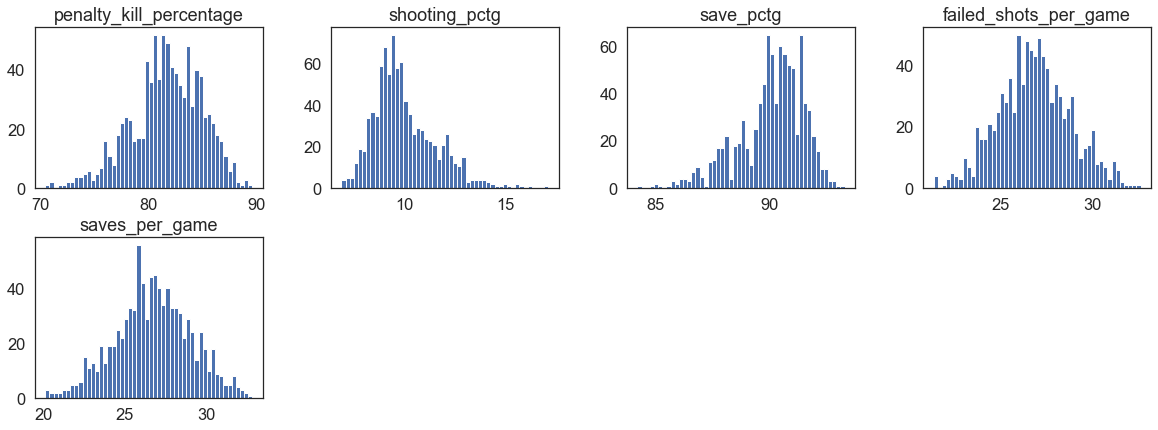


X continuous descriptive stats:


,count,mean,std,min,25%,50%,75%,max
penalty_kill_percentage,922.0,81.658894,3.269763,70.500000,79.800000,81.800000,84.000000,89.600000
shooting_pctg,922.0,9.999783,1.535119,6.900000,9.000000,9.600000,10.875000,17.100000
save_pctg,922.0,90.056725,1.454621,84.200000,89.300000,90.300000,91.100000,93.300000
failed_shots_per_game,922.0,26.820383,1.990341,21.312000,25.452141,26.788285,28.119129,32.651125
saves_per_game,922.0,26.705155,2.339778,20.108898,25.233544,26.717727,28.282316,32.825944


In [7]:
# Distributions of numeric continuous perdictor variables
num_univariate_histogram(
    df = nhl_df, 
    length = 30, 
    width = 20, 
    rows = 8, 
    col = 4,
    font = 1.5,
    kind = 1
)

The independent feature appears to be normally distributed.

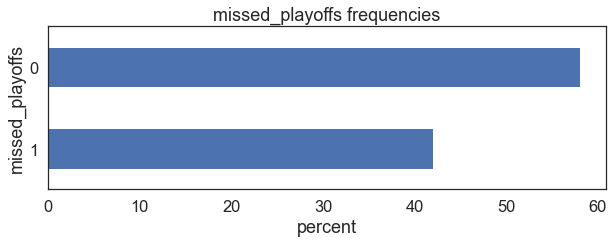

In [8]:
# Retaine missed_playoffs in a separate data frame
cat_df = nhl_df[['missed_playoffs']].astype(str)

# missed_playoffs frequency
cat_univariate_freq(
    df = cat_df, 
    length = 3, 
    width = 10, 
    col_start = 0, 
    col_end = 1, 
    font = 1.5
)

The above shows the frequencies of playoff outcomes for the years of study (1983-2021).

#### Bivariate Analysis

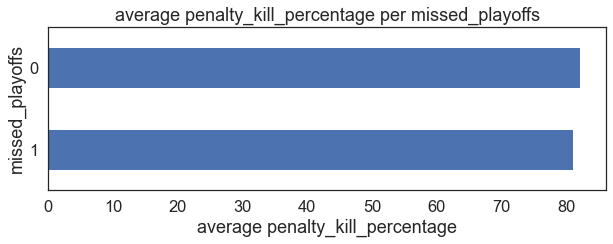

,penalty_kill_percentage,positive
missed_playoffs,,
0,82.0,True
1,81.0,True


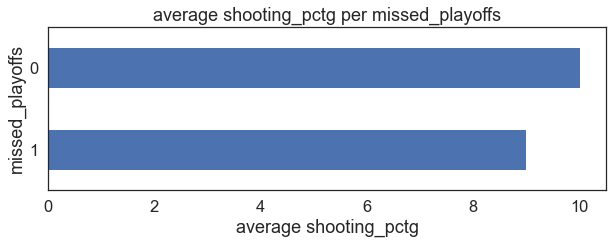

,shooting_pctg,positive
missed_playoffs,,
0,10.0,True
1,9.0,True


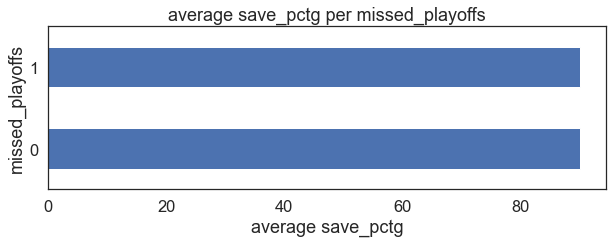

,save_pctg,positive
missed_playoffs,,
0,90.0,True
1,90.0,True


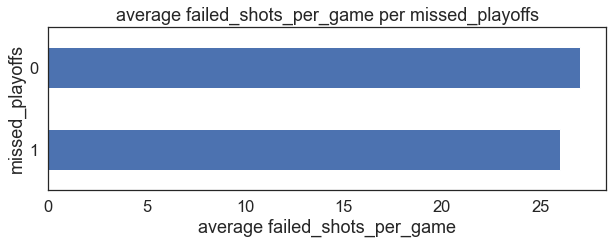

,failed_shots_per_game,positive
missed_playoffs,,
0,27.0,True
1,26.0,True


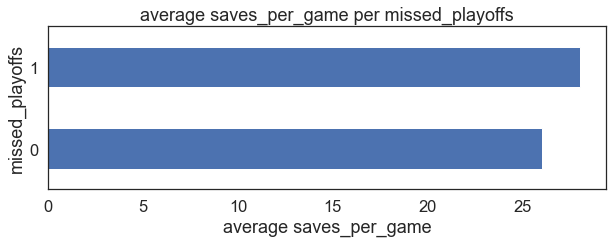

,saves_per_game,positive
missed_playoffs,,
1,28.0,True
0,26.0,True


In [9]:
# Convert missed_playoffs to string data type
nhl_df['missed_playoffs'] = nhl_df['missed_playoffs'].astype(str)
X_num_col = nhl_df_X.columns

# View averages per playoff outcome
for X in X_num_col:
    cat_bivariate_avg_target(
        df = nhl_df, 
        col_start = 0, 
        col_end = 1, 
        target = X, 
        length = 3, 
        width = 10, 
        font = 1.5
    )

The above shows the bivariate comparison between missed_playoffs and the independent features.

In [10]:
# Export final data frame to project directory
nhl_df.to_csv('Data/NHL_1983_2021_Playoff_Data_Removed_Outliers.csv', index = False)

The final data frame is exported to the project directory for further analysis.